The ground Hatree-Fock state is when 1up and 1down orbitals (molecular orbitals) are occupied. This is (1, 1, 0, 0) in fermion occupation basis. In Bravyi-Kitaev basis, this is (1, 0, 0, 0), so just X(0). 

In [1]:
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.utils import uccsd_generator
import numpy as np

from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from forestopenfermion import exponentiate

import numpy as np
import functools

from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian

In [2]:
sim = WavefunctionSimulator()
numQubit = 4

def solve_vqe_ucc_h2(hamiltonian: PauliSum, degree) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    # degree 1: up to T_1
    # degree 2: up to T_2
    
    numParams = 0
    if degree == 1:
        numParams = 2
    elif degree == 2:
        numParams = 3
    params_init = np.random.rand(numParams)*0.5-0.25
    
    def ansatz_energy(params):
        p = None
        p = Program()
        
        # Reference state
        p += X(0)
        
        single_amp = []
        double_amp = []
        
        # occupied: 0,1 unoccupied: 2,3
        count = 0
        single_amp.append([[2,0], params[count]])
        count += 1
        single_amp.append([[3,1], params[count]])
        count += 1
        
        if degree >= 2:
            double_amp.append([[2,0,3,1], params[count]])
        
        ucc_gen = uccsd_generator(single_amp, double_amp)
        ucc_program = exponentiate(bravyi_kitaev(ucc_gen)/(-1j))
        p += ucc_program

        energy = sim.expectation(p, hamiltonian).real
        return energy

    option = {}
    option['disp']=True
    params_answer = minimize(ansatz_energy, params_init, method='L-BFGS-B', options=option).x
    #print(params_answer)
    return ansatz_energy(params_answer)

In [3]:
def get_ground_energy_ucc_h2(interaction_hamil, degree):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe_ucc_h2(pauliop_hamil, degree)


In [4]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_energies_deg1 = []
vqe_energies_deg2 = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(round(bond_length, 2))
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)
    
    ge = get_ground_energy_ucc_h2(h2_interaction_hamil,1)
    vqe_energies_deg1.append(ge)
    print('degree: 1, ground state energy: ', ge)
    ge = get_ground_energy_ucc_h2(h2_interaction_hamil,2)
    vqe_energies_deg2.append(ge)
    print('degree: 2, ground state energy: ', ge)

print(vqe_energies_deg1)
print(vqe_energies_deg2)

degree: 1, ground state energy:  -0.5938277645816001
degree: 2, ground state energy:  -0.6018037168349638
degree: 1, ground state energy:  -0.9043613977107844
degree: 2, ground state energy:  -0.914149708209542
degree: 1, ground state energy:  -1.0429962765064573
degree: 2, ground state energy:  -1.0551597964856745
degree: 1, ground state energy:  -1.1011282431367135
degree: 2, ground state energy:  -1.1162860078249344
degree: 1, ground state energy:  -1.117349035069899
degree: 2, ground state energy:  -1.1361894542708304
degree: 1, ground state energy:  -1.1108503969353456
degree: 2, ground state energy:  -1.134147666357412
degree: 1, ground state energy:  -1.0919140400707403
degree: 2, ground state energy:  -1.1205602806161796
degree: 1, ground state energy:  -1.0661086480737638
degree: 2, ground state energy:  -1.1011503292780256
degree: 1, ground state energy:  -1.0365388735382006
degree: 2, ground state energy:  -1.0791929438801384
degree: 1, ground state energy:  -1.0063725104577

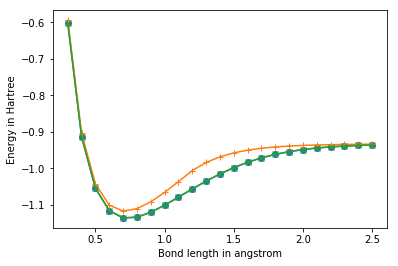

In [7]:
bond_lengths = []
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.1
n_points = 25

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()

    # Print out some results of calculation.
#    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
#        bond_length))
#    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
#    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
#    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
#    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
#        molecule.nuclear_repulsion))
#    for orbital in range(molecule.n_orbitals):
#        print('Spatial orbital {} has energy of {} Hartree.'.format(
#            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]
    
plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'o-')
plt.plot(bond_lengths, vqe_energies_deg1, '+-')
plt.plot(bond_lengths, vqe_energies_deg2, 'x-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [14]:
acc = []
for i in range(len(fci_energies)):
    acc.append(vqe_energies_deg2[i]/fci_energies[i])
print(np.mean(acc))

0.9999999999888547
